# NDVI_smol

### Here we gather Sentinel-2 data to calculate plot NDVI 

In [1]:
# # For Sentinel-2
# # !pip install sentinelsat
# import sys
# !{sys.executable} -m pip install sentinelsat

In [2]:
import ee
import geemap
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
os.chdir("..")
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# # Function to compute NDVI
# def add_ndvi(image):
#     ndvi = image.normalizedDifference(['B8','B4']).rename('NDVI')
#     return image.addBands(ndvi)


def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}
    ).rename('EVI')
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': image.select('B8'), 'RED': image.select('B4')}
    ).rename('SAVI')
    rendvi = image.normalizedDifference(['B8', 'B5']).rename('RENDVI')
    mcari2 = image.expression(
        '((NIR - RE) - 0.2*(NIR - RED)) * (NIR / RE)',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'RE': image.select('B5')}
    ).rename('MCARI2')
    
    return image.addBands([ndvi, evi, ndwi, savi, rendvi, mcari2])





def reduce_region(img, geom, plot_id):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee.Geometry.Polygon(geom['coordinates']),
        scale=10,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'plot_id': plot_id,
        **{band: stats.get(band) for band in ['NDVI', 'EVI', 'NDWI', 'SAVI', 'RENDVI', 'MCARI2']}
    })


## Here we initialize our access to the satellite data download. 
## Requires authentication via browser.

In [4]:
ee.Authenticate()
ee.Initialize()

# load the vineyard polygon (GeoJSON)
vineyard = gpd.read_file("data/polygons/RegressionRidge_smol.geojson")

geoms = [ee.Geometry.Polygon(list(p.exterior.coords)) for p in vineyard.geometry]


### The below code will loop over a given set of years starting in 2016 (earliest available data), search for the polygon coordinates and compute NDVI for our plots. Finally, the data is serialized as a pandas pickle file.

Set dates to search over. Make sure there is a "plots" folder for the plot ndvi data

In [5]:
# --- Settings ---
years = [str(year) for year in range(2016, 2025)]
months = ['01', '12']
days = ['01', '31']
start_dates = [f"{year}-{months[0]}-{days[0]}" for year in years]
end_dates   = [f"{year}-{months[1]}-{days[1]}" for year in years]

os.makedirs("data/ndvi/plots", exist_ok=True)

Loop over years and search database for images overlapping our polygons. Then download the and st

In [6]:
# --- Loop over years ---
for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
    fname = f"data/ndvi/plots/ndvi_{start_date}_to_{end_date}.pkl"
    if os.path.isfile(fname):
        continue

    # Load Sentinel-2 collection
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geoms[0])
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))        # Allowable cloud coverage
        .select(['B2', 'B4', 'B5', 'B8', 'B11'])
        .map(add_indices)  # your NDVI function
    )
    

    # Extract NDVI per plot
    features = []
    for i, geom in enumerate(geoms):
        ndvi_ts = collection.map(lambda img: reduce_region(img, geom, i))
        features.extend(ndvi_ts.getInfo()['features'])
        
    df = pd.DataFrame({
        'date': [f['properties']['date'] for f in features],
        'plot_id': [f['properties']['plot_id'] for f in features],
        'ndvi': [f['properties']['NDVI'] for f in features],
        'evi': [f['properties']['EVI'] for f in features],
        'ndwi': [f['properties']['NDWI'] for f in features],
        'savi': [f['properties']['SAVI'] for f in features],
        'rendvi': [f['properties']['RENDVI'] for f in features],
        'mcari2': [f['properties']['MCARI2'] for f in features]
    })


    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by plot then date to maintain proper time series
    df = df.sort_values(['plot_id', 'date']).reset_index(drop=True)

    for col in ['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']:
        df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
            lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
        )


    # Save to file
    df.to_pickle(fname)

100%|██████████| 9/9 [18:15<00:00, 121.73s/it]


### Now loop over the serialized NDVI years and concatenate. We saved them year by year to prevent processing bloat.

In [7]:
# --- Combine all plot-year files ---
df_list = []
empties = []

for file in tqdm(os.listdir('data/ndvi/plots')):
    if file == 'agg_stats.pkl':
        continue
    if file == 'agg_stats_2025.pkl':
        continue
    # print(file)
    if file == '.ipynb_checkpoints':
        continue
    if file == 'plots':
        continue
    if file == 'ndvi_df.pkl':
        continue
    if file == 'ndvi_2025-01-01_to_2025-12-31.pkl':
        continue

    df_file = pd.read_pickle(os.path.join('data/ndvi/plots', file))
    if df_file.empty:
        empties.append(file)
        continue

    df_list.append(df_file)

# Concatenate all
df = pd.concat(df_list, axis=0).reset_index(drop=True)

100%|██████████| 10/10 [00:00<00:00, 711.06it/s]


In [8]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth
0,2016-02-08,0,0.218413,0.441113,-0.182701,0.327557,0.126218,315.478035,0.258618,0.572677,-0.125649,0.387863,0.153223,502.409407
1,2016-02-25,0,0.245647,0.544963,-0.132300,0.368408,0.145107,435.673661,0.277079,0.609322,-0.110434,0.415551,0.165002,574.664144
2,2016-04-05,0,0.311794,0.731956,-0.061945,0.467625,0.188344,756.076526,0.291818,0.643424,-0.096386,0.437659,0.173109,642.612120
3,2016-04-08,0,0.332460,0.719258,-0.064790,0.498614,0.200342,791.428357,0.320839,0.705776,-0.065018,0.481189,0.190356,777.830932
4,2016-04-15,0,0.350777,0.779831,-0.040194,0.526094,0.205533,914.404022,0.343036,0.730473,-0.040408,0.514484,0.206491,921.142568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31195,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.348602,0.749561,0.007593,0.522835,0.212283,1075.947389
31196,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.282027,0.550129,0.017252,0.422986,0.168160,844.947645
31197,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.216391,0.365968,0.021304,0.324542,0.124619,539.137548
31198,2024-12-09,64,0.043186,-0.189865,0.040914,0.064774,0.022111,85.399354,0.177360,0.279115,0.024414,0.266003,0.098343,390.771039


In [9]:
df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Final sort by plot then date
df = df.sort_values(['plot_id', 'date']).reset_index(drop=True)

In [10]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year
0,2016-02-08,0,0.218413,0.441113,-0.182701,0.327557,0.126218,315.478035,0.258618,0.572677,-0.125649,0.387863,0.153223,502.409407,2016
1,2016-02-25,0,0.245647,0.544963,-0.132300,0.368408,0.145107,435.673661,0.277079,0.609322,-0.110434,0.415551,0.165002,574.664144,2016
2,2016-04-05,0,0.311794,0.731956,-0.061945,0.467625,0.188344,756.076526,0.291818,0.643424,-0.096386,0.437659,0.173109,642.612120,2016
3,2016-04-08,0,0.332460,0.719258,-0.064790,0.498614,0.200342,791.428357,0.320839,0.705776,-0.065018,0.481189,0.190356,777.830932,2016
4,2016-04-15,0,0.350777,0.779831,-0.040194,0.526094,0.205533,914.404022,0.343036,0.730473,-0.040408,0.514484,0.206491,921.142568,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31195,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.348602,0.749561,0.007593,0.522835,0.212283,1075.947389,2024
31196,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.282027,0.550129,0.017252,0.422986,0.168160,844.947645,2024
31197,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.216391,0.365968,0.021304,0.324542,0.124619,539.137548,2024
31198,2024-12-09,64,0.043186,-0.189865,0.040914,0.064774,0.022111,85.399354,0.177360,0.279115,0.024414,0.266003,0.098343,390.771039,2024


### Now we can compute statistics for our plot-year NDVI data

#### Compute across year statistics -- save for later analysis

In [11]:
stats = []
for key, group in df.groupby('plot_id'):
    # print(key, group)
    for yr, data in group.groupby('year'):
        # print(data)
        variance = np.var(data['ndvi'])
        mean = np.mean(data['ndvi'])
        n = len(data['ndvi'])
        stats.append({
            'year':yr,
            'plot':key,
            'mean':mean,
            'variance':variance,
            'n':n
        })
ndvi_stats = pd.DataFrame(stats)

In [12]:
ndvi_stats_gdf = ndvi_stats.merge(
    vineyard[['geometry']],  # keep just geometry
    left_on='plot',
    right_index=True
)

In [13]:
across_year = (
    ndvi_stats
    .groupby('plot')
    .agg(
        mean_of_means=('mean', 'mean'),
        var_of_means=('mean', 'var'),
        mean_of_variance=('variance', 'mean')
    )
)


across_year.to_pickle('data/ndvi/plots/agg_stats.pkl')

In [14]:
aligned_dfs = []
for df in df_list:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    # optional: keep only growing season
    # df = df[(df['doy'] >= 90) & (df['doy'] <= 300)]
    
    # Aggregate multiple observations per day
    df_daily = df.groupby('doy')['ndvi'].mean().reset_index()
    
    year = df['date'].dt.year.iloc[0]
    df_daily.rename(columns={'ndvi_smooth': year}, inplace=True)
    aligned_dfs.append(df_daily)


In [15]:
from functools import reduce

df_all = reduce(lambda left, right: pd.merge(left, right, on='doy', how='outer'), aligned_dfs)
df_all.set_index('doy', inplace=True)

# Sort by DOY to get a proper seasonal curve
df_all.sort_index(inplace=True)


In [16]:
df_all

,ndvi_x,ndvi_y,ndvi_x,ndvi_y,ndvi_x,ndvi_y,ndvi_x,ndvi_y,ndvi
doy,,,,,,,,,
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.380201
9,NaN,NaN,NaN,NaN,0.202715,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,-0.002126,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,0.251761,NaN,NaN,NaN
19,NaN,0.286365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34482,0.025180
356,0.080972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,NaN,0.312153,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
mean_ndvi = df_all.mean(axis=1)
std_ndvi = df_all.std(axis=1)
n_years = df_all.shape[1]

ci_upper = mean_ndvi + 1.96 * std_ndvi / np.sqrt(n_years)
ci_lower = mean_ndvi - 1.96 * std_ndvi / np.sqrt(n_years)


In [18]:
window = 14  # days
mean_smooth = mean_ndvi.rolling(window, center=True, min_periods=1).mean()
ci_upper_smooth = ci_upper.rolling(window, center=True, min_periods=1).mean()
ci_lower_smooth = ci_lower.rolling(window, center=True, min_periods=1).mean()


In [19]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,doy
0,2024-01-07,0,0.530671,1.221129,-0.015867,0.795840,0.323866,1382.603928,0.419421,0.944524,-0.046812,0.629017,0.254419,1052.466135,7
1,2024-02-23,0,0.334100,0.744047,-0.098322,0.501067,0.195289,707.457538,0.416108,0.920384,-0.039370,0.624056,0.252634,1105.562738,54
2,2024-03-07,0,0.393491,0.868395,-0.026248,0.590143,0.244101,1067.336939,0.414855,0.907220,-0.036659,0.622179,0.250646,1113.614445,67
3,2024-03-14,0,0.406171,0.847963,-0.017043,0.609172,0.247280,1264.852547,0.385048,0.817708,-0.039917,0.577487,0.230293,1057.998518,74
4,2024-03-17,0,0.409841,0.854564,-0.025816,0.614670,0.242696,1145.821274,0.378389,0.793232,-0.040256,0.567502,0.226430,1049.556863,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.348602,0.749561,0.007593,0.522835,0.212283,1075.947389,287
4221,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.282027,0.550129,0.017252,0.422986,0.168160,844.947645,312
4222,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.216391,0.365968,0.021304,0.324542,0.124619,539.137548,332
4223,2024-12-09,64,0.043186,-0.189865,0.040914,0.064774,0.022111,85.399354,0.177360,0.279115,0.024414,0.266003,0.098343,390.771039,344


In [20]:
doy_grid = np.arange(0, 365)  # 1 to 365


year_arrays = []

for df in df_list:
    # if df['year'][0] != 2025:
    #     continue
    df = df.copy()
    df['doy'] = pd.to_datetime(df['date']).dt.dayofyear
    # Drop duplicate DOYs to avoid reindexing errors
    df = df.drop_duplicates(subset='doy')
    
    # Interpolate onto full grid
    s = pd.Series(df['ndvi_smooth'].values, index=df['doy'])
    s_interp = s.reindex(doy_grid).interpolate(method='linear', limit_direction='both')
    year_arrays.append(s_interp.values)

In [21]:
year_matrix = np.vstack(year_arrays)  # shape: (n_years, 365)

# Compute mean and standard deviation across years
mean_ndvi = np.nanmean(year_matrix, axis=0)
std_ndvi = np.nanstd(year_matrix, axis=0)

# Smooth with rolling window
window = 14  # roughly 2 weeks
mean_smooth = pd.Series(mean_ndvi).rolling(window, center=True, min_periods=1).mean().values
std_smooth = pd.Series(std_ndvi).rolling(window, center=True, min_periods=1).mean().values

# 95% confidence interval
ci_upper = mean_smooth + 1.96 * std_smooth
ci_lower = mean_smooth - 1.96 * std_smooth

Plots likely inverted: [42 57 59]
Plots likely inverted: [15]
Plots likely inverted: [15 29 42 51 52 53]
Plots likely inverted: [ 0  5  6  7  8 16 35 42 58 59 64]
Plots likely inverted: [15 42]
Plots likely inverted: [ 7  8 13 17 42]
Plots likely inverted: [42]
Plots likely inverted: []
Plots likely inverted: [36 37 38 39 40 41 42 43 44 47 48 49 50]


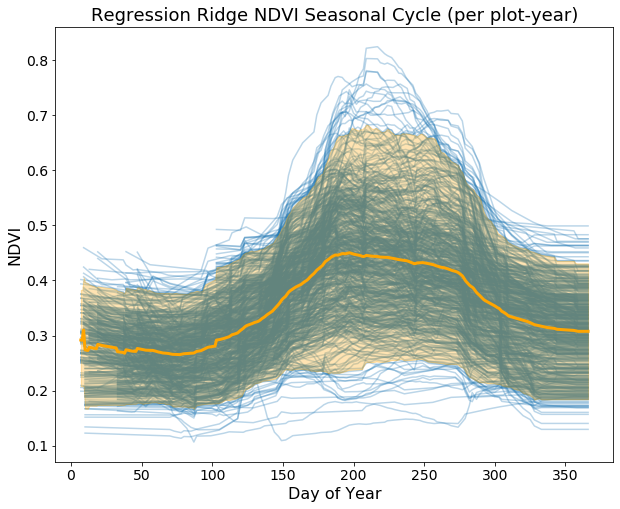

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

all_ndvi = []
# Define DOY grids
doy_full = np.arange(0, 367)  # full year
# doy_full_2025 = np.arange(0, 269)     # clip 2025 at day 266
plt.figure(figsize=(10, 8))
def is_inverted(df_plot):
    early = df_plot[df_plot['date'].dt.dayofyear < 180]['ndvi'].mean()
    late  = df_plot[df_plot['date'].dt.dayofyear >= 180]['ndvi'].mean()
    return early > late

for n, df in enumerate(df_list):
# df = df_list[7].copy()
    # print(n)
    # if n == 7:
    #     continue
# For each plot

    inverted_plots = df.groupby('plot_id').filter(is_inverted)['plot_id'].unique()
    print("Plots likely inverted:", inverted_plots)


    # for pid in inverted_plots:
    #     mask = df['plot_id'] == pid
    #     df.loc[mask, 'ndvi'] = df.loc[mask, 'ndvi'].iloc[::-1].values
    #     df.loc[mask, 'ndvi_smooth'] =df.loc[mask, 'ndvi_smooth'].iloc[::-1].values

    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    # if df['year'].mean() != 2025:
    #     continue
    # print(df)
    df["doy"] = df["date"].dt.dayofyear
    df["ndvi_smooth"] = df["ndvi"].rolling(window = 14, center=True, min_periods=1).mean()

    # Skip very low NDVI plots
    # if np.mean(df["ndvi_smooth"]) < 0.2:
    #     continue

    # df = df.drop(drop_index)
    plot_id = df.get("plot_id", None)

    # Group by plot and year
    if plot_id is not None:
        group_cols = ["plot_id", "year"]
    else:
        # fallback: treat entire df as one plot
        df["plot_id"] = 0
        group_cols = ["plot_id", "year"]

    # 
    # doy_full = doy_full_2025 ifdf['year'].iloc[0] == 2025 else doy_full_default

    for (p_id, year), group in df.groupby(group_cols):
        # Aggregate duplicates per DOY
        group_agg = group.groupby("doy", as_index=False)["ndvi_smooth"].mean()

        # Reindex to full DOY and interpolate missing values
        group_interp = group_agg.set_index("doy").reindex(doy_full)
        group_interp["ndvi_smooth"] = group_interp["ndvi_smooth"].interpolate()
    #     if group_interp.loc[365].values[0] < 0.18:
    #         continue

    #     if group_interp.loc[365].values[0] > 0.27:
    #         continue
        # Plot per plot-year
        label = f"Plot {p_id} - {year}"
        plt.plot(doy_full, group_interp["ndvi_smooth"], alpha=0.3, color='#1f77b4',)

        all_ndvi.append(group_interp["ndvi_smooth"].values)
        
# Compute mean and 95% CI across all plot-years
# Convert all_ndvi to 2D array and compute mean + CI
all_ndvi_series = [pd.Series(a) for a in all_ndvi]  # convert each to Series
all_ndvi_df = pd.concat(all_ndvi_series, axis=1)   # columns = plot-years
mean_smooth = all_ndvi_df.mean(axis=1)
ci_lower = all_ndvi_df.quantile(0.025, axis=1)
ci_upper = all_ndvi_df.quantile(0.975, axis=1)
# mean_smooth = np.nanmean(all_ndvi, axis=0)
# ci_lower = np.nanpercentile(all_ndvi, 2.5, axis=0)
# ci_upper = np.nanpercentile(all_ndvi, 97.5, axis=0)

# Plot mean ± 95% CI
# plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.5, label='95% CI')
# plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, label='Mean NDVI (smoothed)')
plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# for df_values in all_ndvi:
#     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
plt.xlabel("Day of Year", fontsize=16)
plt.ylabel("NDVI", fontsize=16)
plt.title("Regression Ridge NDVI Seasonal Cycle (per plot-year)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=12, loc="upper left")
plt.savefig('fig.png')
plt.show()


In [23]:
ndvi = pd.DataFrame(all_ndvi)

In [24]:
import pandas as pd
import numpy as np

# assume you have df with columns: plot_id, doy, ndvi

def is_inverted(curve):
    # Split NDVI by season (rough cut)
    spring = curve[(curve['doy'] >= 60) & (curve['doy'] <= 120)]['ndvi'].mean()
    summer = curve[(curve['doy'] >= 150) & (curve['doy'] <= 220)]['ndvi'].mean()
    fall   = curve[(curve['doy'] >= 230) & (curve['doy'] <= 270)]['ndvi'].mean()
    
    # Flag if summer NDVI is *lower* than both spring and fall
    return summer < spring and summer < fall

# Apply per plot-year
inverted_plots = []
for (plot, year), group in df.groupby(['plot_id','year']):
    if is_inverted(group):
        inverted_plots.append((plot, year))

print("Inverted plot-years:", inverted_plots)


Inverted plot-years: [(40, 2024), (41, 2024), (44, 2024), (48, 2024), (50, 2024)]


In [25]:
inverted_idx = [inverted_plots[i][0] for i in range(0, len(inverted_plots), 1)]

In [26]:
df_ndvi = pd.DataFrame({
    'doy': doy_full,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [27]:
# years = list(range(2016, 2026))  
rows_per_year = 65

for n, year in enumerate(years):
    start = n * rows_per_year
    end = (n + 1) * rows_per_year
    ndvi.loc[start:end-1, 'year'] = str(year)
    

In [28]:
ndvi

,0,1,2,3,4,5,6,7,8,9,...,358,359,360,361,362,363,364,365,366,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.318940,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,2016
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.350503,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,2016
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400432,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,2016
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.360768,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,2016
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.331350,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326435,0.326186,0.325937,...,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,2024
581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287174,0.286999,0.286825,...,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,2024
582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.367454,0.367135,0.366815,...,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,2024
583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322922,0.322658,0.322395,...,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,2024


In [29]:
rows_per_year = 65
# years = list(range(2025, 2026))  
n_years = len(years)

# total rows should match df
assert ndvi.shape[0] == rows_per_year * n_years

# assign year
ndvi['year'] = np.repeat(years, rows_per_year)

# assign plot_id (repeats 0..64 for each year)
ndvi['plot_id'] = np.tile(np.arange(rows_per_year), n_years)


In [30]:
ndvi_copy = ndvi.copy()

In [31]:
ndvi = ndvi_copy.copy()

In [32]:
ndvi

,0,1,2,3,4,5,6,7,8,9,...,359,360,361,362,363,364,365,366,year,plot_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,2016,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,2016,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,2016,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,2016,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,2016,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326435,0.326186,0.325937,...,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,2024,60
581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287174,0.286999,0.286825,...,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,2024,61
582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.367454,0.367135,0.366815,...,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,2024,62
583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322922,0.322658,0.322395,...,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,2024,63


In [33]:
import numpy as np
import pandas as pd

# Assume ndvi_df has columns: [0..364] for DOY, plus 'year', 'plot_id'

# Compute curve-level features
curve_stats = []
for idx, row in ndvi.iterrows():
    # Grab the first 365 columns (days of year NDVI values)
    ndvi_vals = row[0:366]
    # print(ndvi_vals)

    # ignore NaNs
    # ndvi_vals = ndvi_vals[~np.isnan(ndvi_vals)]
    if len(ndvi_vals) == 0:
        continue

#     if ndvi_vals[365] < 0.18:
#         continue
        
#     if ndvi_vals[365] > 0.27:
#         continue
        
        
        
    mean_val = np.mean(ndvi_vals)
    peak_val = np.max(ndvi_vals)
    min_val = np.min(ndvi_vals)
    amplitude = peak_val - min_val

    curve_stats.append({
        "index": idx,
        "mean": mean_val,
        "peak": peak_val,
        "amplitude": amplitude
    })

curve_stats = pd.DataFrame(curve_stats)

# === Define filters ===
mean_mean, mean_std = curve_stats["mean"].mean(), curve_stats["mean"].std()
mask_mean_outlier = ~curve_stats["mean"].between(mean_mean - 3.5*mean_std,
                                                 mean_mean + 3.5*mean_std)

peak_mean, peak_std = curve_stats["peak"].mean(), curve_stats["peak"].std()
mask_peak_outlier = ~curve_stats["peak"].between(peak_mean - 3.5*peak_std,
                                                 peak_mean + 3.5*peak_std)

mask_flat = curve_stats["amplitude"] < 0.161  # nearly flat curves

# Combine masks
bad_idx = curve_stats.loc[mask_mean_outlier | mask_peak_outlier | mask_flat, "index"]

# === Filter original wide table ===
ndvi_filtered = ndvi.drop(index=bad_idx)

print(f"Dropped {len(bad_idx)} outlier plot-years out of {len(ndvi)} total")


Dropped 157 outlier plot-years out of 585 total


In [34]:
ndvi_filtered

,0,1,2,3,4,5,6,7,8,9,...,359,360,361,362,363,364,365,366,year,plot_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,2016,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,2016,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,2016,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,2016,4
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310729,0.310729,0.310729,0.310729,0.310729,0.310729,0.310729,0.310729,2016,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326435,0.326186,0.325937,...,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,2024,60
581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287174,0.286999,0.286825,...,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,2024,61
582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.367454,0.367135,0.366815,...,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,2024,62
583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322922,0.322658,0.322395,...,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,2024,63


/home/simonhans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/simonhans/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


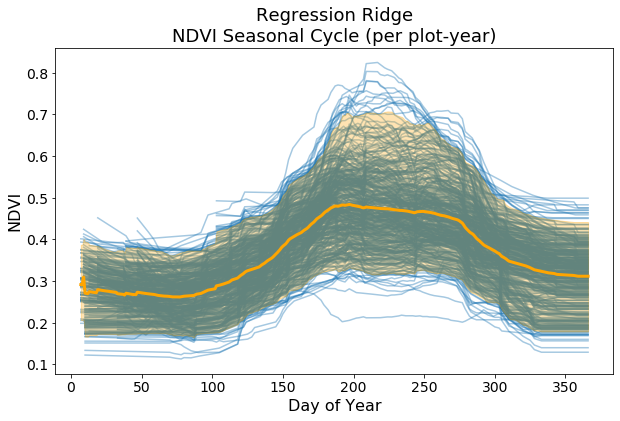

In [35]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,6))
# Extract DOY columns (all ints, except 'year')
doy_cols = [c for c in ndvi_filtered.columns if isinstance(c, (int, np.integer))]

# X-axis = DOY numbers
doy_full = np.arange(len(doy_cols))

filtered_ndvi = []

# Loop through rows
for idx, row in ndvi_filtered.iterrows():
    year = row["year"]
    ndvi_values = row[doy_cols].values.astype(float)
    # print(doy_cols[:10], "…", doy_cols[-10:])

    # skip all-NaN rows
    if np.isnan(ndvi_values).all():
        continue
    if ndvi_values[200] < 0.2:
        continue
        
#     if ndvi_values[8] > 0.27:
#         continue
        
#     if ndvi_values[100] > 0.3:
#         continue
#     if ndvi_values[100] < 0.12:
#         continue
        
#     if ndvi_values[365] < 0.18:
#         continue
        
#     if ndvi_values[365] > 0.27:
        continue
    plt.plot(doy_full, ndvi_values, alpha=0.4, color="#1f77b4")
    filtered_ndvi.append(ndvi_values)
    
filtered_ndvi = np.array(filtered_ndvi)
mean_smooth = np.nanmean(filtered_ndvi, axis=0)
ci_lower = np.nanpercentile(filtered_ndvi, 2.5, axis=0)
ci_upper = np.nanpercentile(filtered_ndvi, 97.5, axis=0)

plt.xlabel("Day of Year")
plt.ylabel("NDVI (smoothed)")
plt.title("NDVI curves by plot-year")

plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# for df_values in all_ndvi:
#     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
plt.xlabel("Day of Year", fontsize=16)
plt.ylabel("NDVI", fontsize=16)
plt.title("Regression Ridge\nNDVI Seasonal Cycle (per plot-year)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=12, loc="upper left")
plt.savefig('img/ndvi_spaghetti.png')
plt.show()
plt.show()







# # Compute mean and 95% CI across all plot-years

# # Plot mean ± 95% CI
# # plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.5, label='95% CI')
# # plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, label='Mean NDVI (smoothed)')
# plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
# plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# # for df_values in all_ndvi:
# #     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
# plt.xlabel("Day of Year", fontsize=16)
# plt.ylabel("NDVI", fontsize=16)
# plt.title("Regression Ridge NDVI Seasonal Cycle (per plot-year)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.legend(fontsize=12, loc="upper left")
# # plt.savefig('fig.png')
# plt.show()


In [36]:
ndvi_filtered

,0,1,2,3,4,5,6,7,8,9,...,359,360,361,362,363,364,365,366,year,plot_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,0.312793,2016,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,0.344861,2016,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,0.394554,2016,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,0.326979,2016,4
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310729,0.310729,0.310729,0.310729,0.310729,0.310729,0.310729,0.310729,2016,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326435,0.326186,0.325937,...,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,0.301256,2024,60
581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287174,0.286999,0.286825,...,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,0.386504,2024,61
582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.367454,0.367135,0.366815,...,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,0.332700,2024,62
583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322922,0.322658,0.322395,...,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,0.366223,2024,63


In [37]:
print(np.nanmin(ndvi_filtered[doy_cols].values), np.nanmax(ndvi_filtered[doy_cols].values))


0.10643903655411749 0.8248169511463744


In [38]:
df_ndvi = pd.DataFrame({
    'doy': doy_full,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [39]:
df_ndvi

,doy,mean_ndvi,ci_lower,ci_upper
0,0,NaN,NaN,NaN
1,1,NaN,NaN,NaN
2,2,NaN,NaN,NaN
3,3,NaN,NaN,NaN
4,4,NaN,NaN,NaN
...,...,...,...,...
362,362,0.311849,0.179386,0.441906
363,363,0.311849,0.179386,0.441906
364,364,0.311849,0.179386,0.441906
365,365,0.311849,0.179386,0.441906


In [40]:
# ndvi.to_pickle('data/plot_ndvi.pkl')

In [41]:
ndvi_filtered.to_pickle('data/plot_ndvi_filtered.pkl')

In [42]:
# ndvi_filtered.to_pickle('data/plot_ndvi_filtered_2025.pkl')